In [1]:
# Load Libaries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from numpy import trapz
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.ensemble import RandomForestClassifier
import statistics

In [2]:
# Preprocessing
df = pd.read_csv('data.csv')
df = df.drop(df.columns[0], axis=1)
print(df.head())

# Define features and target
X = df.values[:, 1:7]
Y = df.values[:,0]

# Split Data in Train and Test Data
X_traindata, X_testdata, Y_traindata, Y_testdata = train_test_split(X, Y, test_size=0.30,random_state=101)

   returnLabel  totalAmount  c_0  c_1  c_2  c_3  c_4  c_5
0            0          240    1    0    3    1    3    0
1            0           79    0    0    1    0    0    0
2            0           24    0    0    1    1    0    0
3            0          504    0    3    0    0    1    2
4            0          190    1    0    1    1    2    0


# Cross Validation - From Scratch

In [3]:
# Divide the Training Data into k folds
def cross_validation_divide (data, k):
    # Foldsize = Dataframe Size / Number of Folds (k)
    foldsize = int(data["returnLabel"].count() / k)
    
    # Folds
    folds = []
    
    # Create Folds
    c = 1
    while (c <= k):
        folds.append(data.iloc[:foldsize]) 
        data = data.iloc[foldsize:]
        c = c + 1  
    
    return folds

In [4]:
# Random Forest
def random_forest (X_train, Y_train, n_estimators, max_depth):
    # Create new Random Forest Classifier
    rf = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth, random_state=0, n_jobs=-1)

    # Train the model
    model = rf.fit(X_train, Y_train)
    return model

In [5]:
def get_area_under_the_curve (model, X_test, y_test):
    # For ROC
    tprf = model.predict_proba(X_test)[:,1]
    fprf, tprf, threshold = roc_curve(y_test, tprf)
    
    # Calculate the area under the ROC Curve
    area = trapz(tprf, fprf)
    return area

In [6]:
def cross_validation_train (folds, n_estimators, max_depth):
    # Getting the size of the folds (= k)
    k = len(folds)
    
    # Collecting the results
    cv_results = []
    
    # Running through the folds and calculating the CV Results
    n = 0
    
    while (n < k):
        # Separate the testdata
        testdata = folds[n]
        
        traindata = pd.DataFrame()
        f = 0
        
        # Merge all other to one dataframe (one dataset)
        while (f < k):
            if (f != n):
                traindata = pd.concat([traindata, folds[f]])
                
            f = f + 1
            
        # Do the Train!
        # Define features and targets
        X = traindata.values[:, 1:7]
        Y = traindata.values[:,0]
        
        X_test = testdata.values[:, 1:7]
        Y_test = testdata.values[:,0]
        
        # Call the Random Forest
        model = random_forest(X, Y, n_estimators, max_depth)
        area = get_area_under_the_curve(model, X_test, Y_test)
        cv_results.append(area)
        
        n = n + 1
        
    return cv_results

In [7]:
class setting:
    def __init__(self, n_estimators, max_depth):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.cv_results = []
        self.cv_median = 0

In [8]:
# Modify the Data for another split into the fols
df1 = pd.DataFrame(X_traindata, columns=['totalAmount', 'c_1', 'c_2', 'c_3', 'c_4', 'c_5'])
df2 = pd.DataFrame(Y_traindata, columns=['returnLabel'])
dfTrain = pd.concat([df2, df1], axis=1)

In [9]:
folds = cross_validation_divide(dfTrain, 4)

# Settings with different hyperparameters
set1 = setting(10, 10)
set2 = setting(100, 20)
set3 = setting(100, 30)
set4 = setting(200, 10)
set5 = setting(200, 30)

sets = [set1, set2, set3, set4, set5]

In [10]:
# Train with the different hyperparameters
for s in sets:
    s.cv_results = cross_validation_train(folds, s.n_estimators, s.max_depth)
    
    # Average of the results
    s.cv_median = statistics.median(s.cv_results)

# Take the best one and train with this one the overall data
bestSetting = set1
for s in sets:
    if (bestSetting.cv_median < s.cv_median):
        bestSetting = s

print("Max_Depth: ", bestSetting.max_depth)
print("N_Estimators: ",bestSetting.n_estimators)

# Train with the best hyperparameters
rf = RandomForestClassifier(random_state=0, n_jobs=-1, n_estimators = bestSetting.n_estimators, max_depth = bestSetting.max_depth)
print(rf)

# Train the model
modelO = rf.fit(X_traindata, Y_traindata)

Max_Depth:  10
N_Estimators:  200
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


In [11]:
# Doing a default RandomForest
rfComp = RandomForestClassifier(random_state=0, n_jobs=-1)
print(rfComp)

# Train the model
modelComp = rfComp.fit(X_traindata, Y_traindata)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


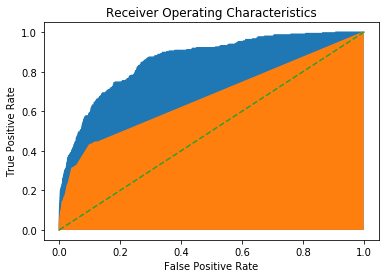

In [12]:
# Plot the curves
# For the RandomForest with the best hyperparameters
tprf = modelO.predict_proba(X_testdata)[:,1]
fprf, tprf, threshold = roc_curve(Y_testdata, tprf)

# For the Compare RandomForest
tprfComp = modelComp.predict_proba(X_testdata)[:,1]
fprfComp, tprfComp, thresholdComp = roc_curve(Y_testdata, tprfComp)

plt.title("Receiver Operating Characteristics")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(fprf, tprf)
plt.plot(fprfComp, tprfComp)

plt.plot([0, 1], ls="--")
plt.fill_between(fprf, tprf)
plt.fill_between(fprfComp,tprfComp)

plt.show()